### Multivariate Normal Distribution 

A Gaussian distribution is a probability distribution that is characterized by a distinctive bell curve shape and is defined by the mean and the variance. 

A multivariate standard normal distribution is a multivariate distribution with a zero-valued mean vector and identity covariance matrix which means that the distribution is independent in each dimensions. 

- Variational autoencoders assume that there is no correlation between dimensions in the latent space.Here, the encoder will take each input image and encode it to two vectors that together define a multivariate normal distribution in the latent space.

If mu is the mean point of the distribution and logvar is the logarithm of the variance of each dimension, we can get get sample from this distribution as :

z = mu + sigma*epsilon 
where 
sigma = exp(log_var/2)
epsilon is the random point between 0 and 1 

In [1]:
%load_ext autoreload
%autoreload 2 

import numpy as np 
import matplotlib.pyplot as plt 
import tensorflow as tf 
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
    
from tensorflow.keras import layers,models,datasets,callbacks,losses,optimizers,metrics
import tensorflow.keras.backend as K

from utils import display

2023-07-17 03:32:20.159079: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-17 03:32:20.239512: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-17 03:32:20.262466: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-07-17 03:32:20.652555: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

1 Physical GPUs, 1 Logical GPUs


2023-07-17 03:32:21.257216: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-17 03:32:21.279986: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-17 03:32:21.280127: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-17 03:32:21.280717: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

In [2]:
IMAGE_SIZE = 32 
BATCH_SIZE = 100 
VALIDATION_SPLIT = 0.2 
EMBEDDING_DIM = 2 
EPOCHS = 5 
BETA = 500 

In [3]:
#load the data 
(x_train,y_train), (x_test,y_test) = datasets.fashion_mnist.load_data()

In [4]:
#preprocess the data 
def preprocess(imgs):
    """
    Normalize and reshape the images
    """
    imgs = imgs.astype("float32")/255.0
    imgs = np.pad(imgs,((0,0),(2,2),(2,2)),constant_values=0.0)
    imgs = np.expand_dims(imgs,-1)
    return imgs

x_train = preprocess(x_train)
x_test = preprocess(x_test)

### Build the variational autoencoder

We can create a new layer by subclassing the base Layer class. In the method named call, we define how the tensor is being transformed. 

In [5]:
class Sampling(layers.Layer):
    def call(self,inputs):
        z_mean, z_log_var = inputs 
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch,dim))
        return z_mean + tf.exp(0.5*z_log_var) * epsilon

In [6]:
# Encoder
encoder_input = layers.Input(
    shape=(IMAGE_SIZE, IMAGE_SIZE, 1), name="encoder_input"
)
x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(
    encoder_input
)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)
shape_before_flattening = K.int_shape(x)[1:]  # the decoder will need this!

x = layers.Flatten()(x)
z_mean = layers.Dense(EMBEDDING_DIM, name="z_mean")(x)
z_log_var = layers.Dense(EMBEDDING_DIM, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 32)   320         ['encoder_input[0][0]']          
                                                                                                  
 conv2d_1 (Conv2D)              (None, 8, 8, 64)     18496       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 4, 4, 128)    73856       ['conv2d_1[0][0]']               
                                                                                            

In [7]:
#Decoder 

decoder_input = layers.Input(shape=(EMBEDDING_DIM,),name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    128,(3,3),strides=2, activation="relu",padding="same")(x)
x = layers.Conv2DTranspose(
    64,(3,3),strides=2,activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32,(3,3),strides=2,activation="relu", padding="same")(x)

decoder_output = layers.Conv2D(
    1,
    (3,3),
    strides=1,
    activation="sigmoid",
    padding="same",
    name="decoder_output",)(x)

decoder = models.Model(decoder_input,decoder_output)
decoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 2048)              6144      
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        147584    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 64)       73792     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 32, 32, 32)       18464 

### Kullback-Leiber (KL) divergence 
KL divergence measures how much one probability distribution differes from another. We measure how much our normal distribution with z_mean and z_log_var differ with the standard normal distribution. It penalizes the network for encoding observations to z_mean and z_log_var that differes significantly from the parameters of a standard normal distribution



Subclassing base Model to define custum run and custom train step method

In [36]:
class VAE(models.Model):
    def __init__(self,encoder,decoder,**kwargs):
        super(VAE,self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder 
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")
        
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ] 
    
    def call(self,inputs):
        """
        Call the model on particular input 
        """
        z_mean,z_log_var,z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean,z_log_var,reconstruction 
    
    def train_step(self,data):
        """
        Steps run during training
        """
        #it alloes the computation of gradients of operation executed during the forward pas 
        #useful mechanism for calculating the gradient of custom loss function
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            reconstruction_loss = tf.reduce_mean(BETA*losses.binary_crossentropy(data,reconstruction,axis=(1,2,3)))
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5 *
                    (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            total_loss = reconstruction_loss + kl_loss
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads,self.trainable_weights))
        
        self.total_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {m.name:m.result() for m in self.metrics}
    
    def test_step(self,data):
        """
        Step run during validation
        """
        if isinstance(data,tuple):
            data = data[0]
        
        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
            BETA*
            losses.binary_crossentropy(data, reconstruction, axis = (1,2,3))
        )
        
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5*(1+z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis = 1,
            )
        )
        total_loss = reconstruction_loss + kl_loss 
        
        return {
            "loss": total_loss,
            "reconstruction_loss" : reconstruction_loss,
            "kl_loss": kl_loss,
        }
            
                                        
        

In [9]:
#create a variational autoencoder 
vae = VAE(encoder, decoder)

### Train the variational autoencoder

In [10]:
#Compile the variational autoencoder 
optimizer = optimizers.Adam(learning_rate = 0.0005)
vae.compile(optimizer=optimizer)

In [11]:
#create a model save checkpoint 
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint",
    save_weights_only=False,
    save_freq = "epoch",
    monitor="loss",
    mode = "min",
    save_best_only=True,
    verbose=0
)
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")
                                             

In [12]:
vae.fit(
    x_train,
    epochs=EPOCHS,
    batch_size= BATCH_SIZE,
    shuffle=True,
    validation_data = (x_test,x_test),
    callbacks=[model_checkpoint_callback,tensorboard_callback],
)

Epoch 1/5


2023-07-17 03:32:23.645007: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8400
2023-07-17 03:32:24.743718: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


600/600 [==============================] - 7s 7ms/step - total_loss: 154.8435 - reconstruction_loss: 0.0000e+00 - kl_loss: 4.4905 - val_loss: 140.5144 - val_reconstruction_loss: 135.5545 - val_kl_loss: 4.9600
Epoch 2/5
600/600 [==============================] - 4s 6ms/step - total_loss: 130.3495 - reconstruction_loss: 0.0000e+00 - kl_loss: 4.9454 - val_loss: 137.1545 - val_reconstruction_loss: 131.9898 - val_kl_loss: 5.1647
Epoch 3/5
600/600 [==============================] - 4s 7ms/step - total_loss: 128.7252 - reconstruction_loss: 0.0000e+00 - kl_loss: 4.9962 - val_loss: 136.5476 - val_reconstruction_loss: 131.4298 - val_kl_loss: 5.1177
Epoch 4/5
600/600 [==============================] - 4s 7ms/step - total_loss: 127.8208 - reconstruction_loss: 0.0000e+00 - kl_loss: 5.0632 - val_loss: 135.9015 - val_reconstruction_loss: 130.7636 - val_kl_loss: 5.1379
Epoch 5/5
600/600 [==============================] - 4s 6ms/step - total_loss: 127.3147 - reconstruction_loss: 0.0000e+00 - kl_loss: 5

In [13]:
#save the final models
vae.save("./models/vae")
encoder.save("./models/encoder")
decoder.save("./models/decoder")

INFO:tensorflow:Assets written to: ./models/vae/assets


INFO:tensorflow:Assets written to: ./models/vae/assets


INFO:tensorflow:Assets written to: ./models/encoder/assets


INFO:tensorflow:Assets written to: ./models/encoder/assets


INFO:tensorflow:Assets written to: ./models/decoder/assets


INFO:tensorflow:Assets written to: ./models/decoder/assets


### Reconstruct using the variational autoencoder 

In [33]:
#select a subset of the test set 
n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

157/157 [==============================] - 0s 2ms/step
Example real clothing items


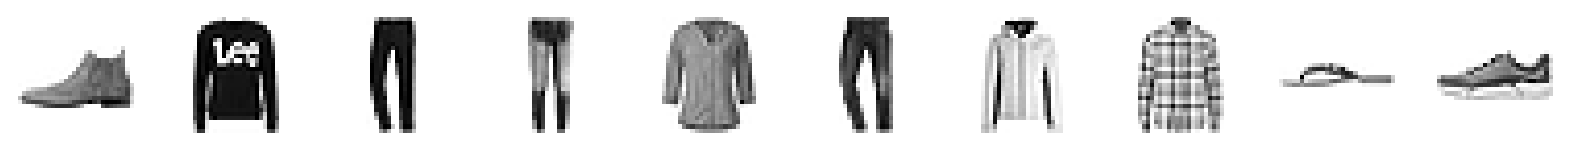

Reconstuctions


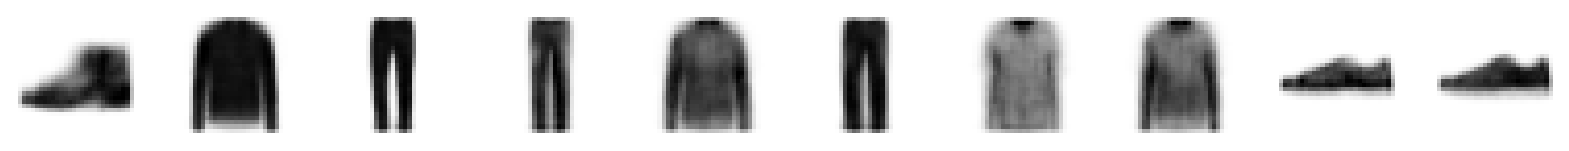

In [19]:
#create autoencoder predictions and display
z_mean,z_log_var, reconstructions = vae.predict(example_images)
print("Example real clothing items")
display(example_images)
print("Reconstuctions")
display(reconstructions)

### Embed the example images

In [20]:
#Encode the examples images 
z_mean, z_var, z = encoder.predict(example_images)

157/157 [==============================] - 0s 728us/step


In [22]:
#some exmples of the embedding 
print(z[:10])

[[ 1.2110767  -0.5331533 ]
 [-0.669408    1.3075336 ]
 [-2.0828848  -1.6337954 ]
 [-1.047782   -1.8112454 ]
 [-0.23022787  0.69298565]
 [-1.3886625  -0.83318496]
 [-0.18407199 -0.5099509 ]
 [-0.2285277   0.16591066]
 [ 2.452588   -0.9833866 ]
 [ 2.2618675   0.28451303]]


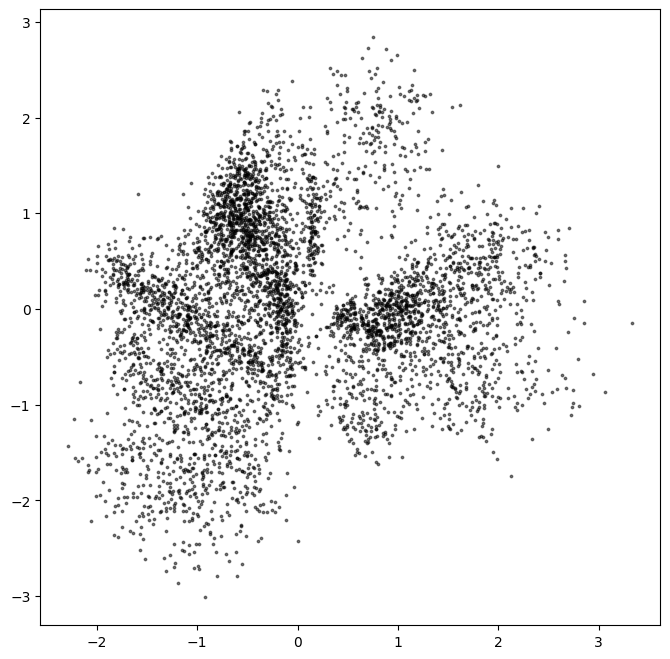

In [23]:
# Show the encoded points in 2D space
figsize = 8

plt.figure(figsize=(figsize, figsize))
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=3)
plt.show()

### Generate using the decoder 

In [24]:
#sample some points in the latent space, from the standard normal distribution 
grid_width, grid_height = (6,3)
z_sample = np.random.normal(size=(grid_width * grid_height, 2))

In [31]:
len(z_sample)

18

In [25]:
# Decode the sampled points 
reconstructions = decoder.predict(z_sample)

1/1 [==============================] - 0s 81ms/step


In [28]:
#convert original embeddings and sampled embeddings to p-values
from scipy.stats import norm

p = norm.cdf(z)
p_sample = norm.cdf(z_sample)

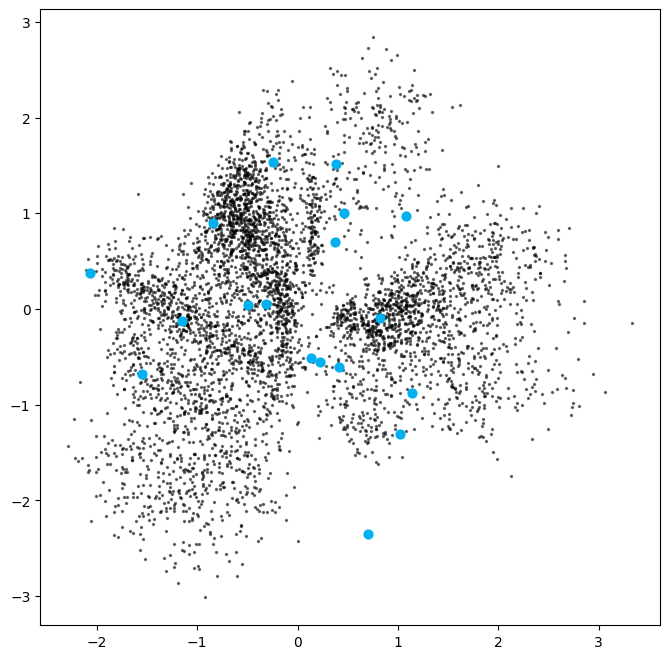

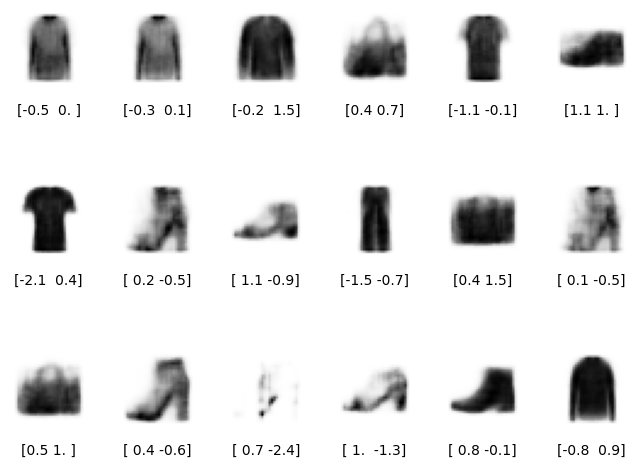

In [29]:
# Draw a plot of...
figsize = 8
plt.figure(figsize=(figsize, figsize))

# ... the original embeddings ...
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=2)

# ... and the newly generated points in the latent space
plt.scatter(z_sample[:, 0], z_sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

# Add underneath a grid of the decoded images
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(z_sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

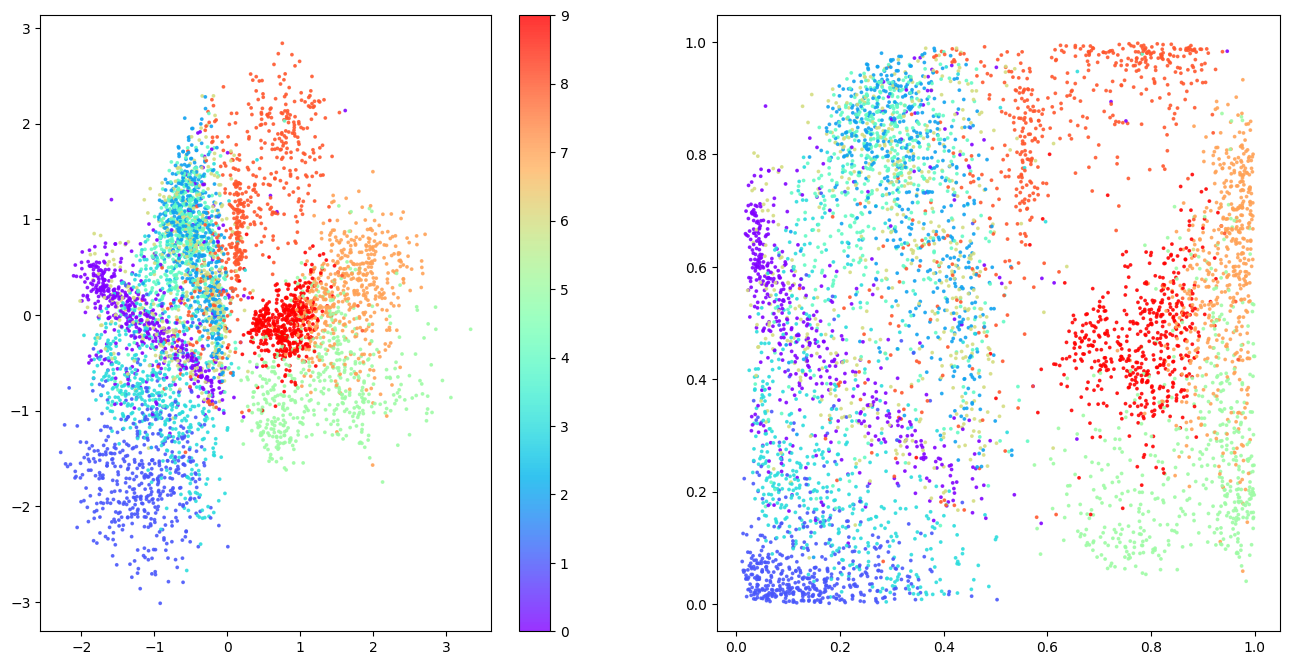

In [34]:
# Colour the embeddings by their label (clothing type - see table)
figsize = 8
fig = plt.figure(figsize=(figsize * 2, figsize))
ax = fig.add_subplot(1, 2, 1)
plot_1 = ax.scatter(
    z[:, 0], z[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3
)
plt.colorbar(plot_1)
ax = fig.add_subplot(1, 2, 2)
plot_2 = ax.scatter(
    p[:, 0], p[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3
)
plt.show()

8/8 [==============================] - 0s 3ms/step


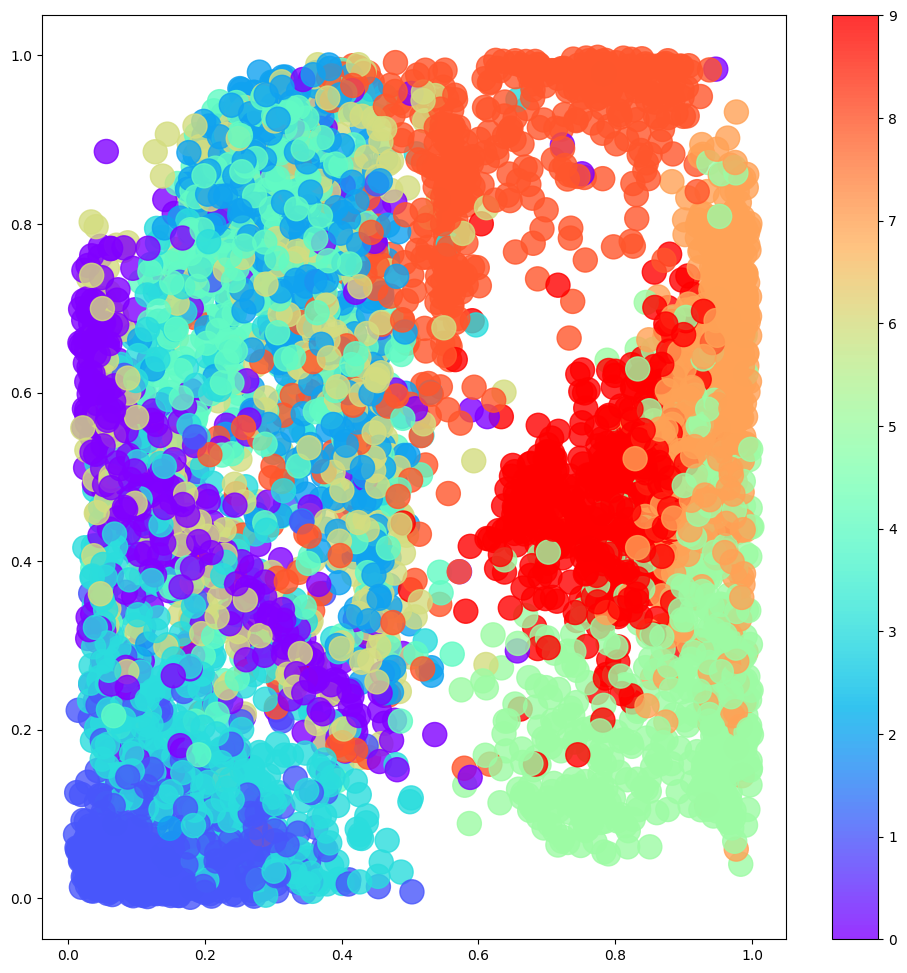

In [ ]:
# Colour the embeddings by their label (clothing type - see table)
figsize = 12
grid_size = 15
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    p[:, 0], p[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=300
)
plt.colorbar()

x = norm.ppf(np.linspace(0, 1, grid_size))
y = norm.ppf(np.linspace(1, 0, grid_size))
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.array(list(zip(xv, yv)))

reconstructions = decoder.predict(grid)
# plt.scatter(grid[:, 0], grid[:, 1], c="black", alpha=1, s=10)
plt.show()

fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")